In [63]:
%load_ext autoreload
%autoreload 2
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib# import lane_lines.calibration
# importlib.reload(lane_lines.calibration)
from lane_lines.calibration import load_calibration
from lane_lines import sobel

cam_matrix, dist_coeff = load_calibration('camera_cal')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


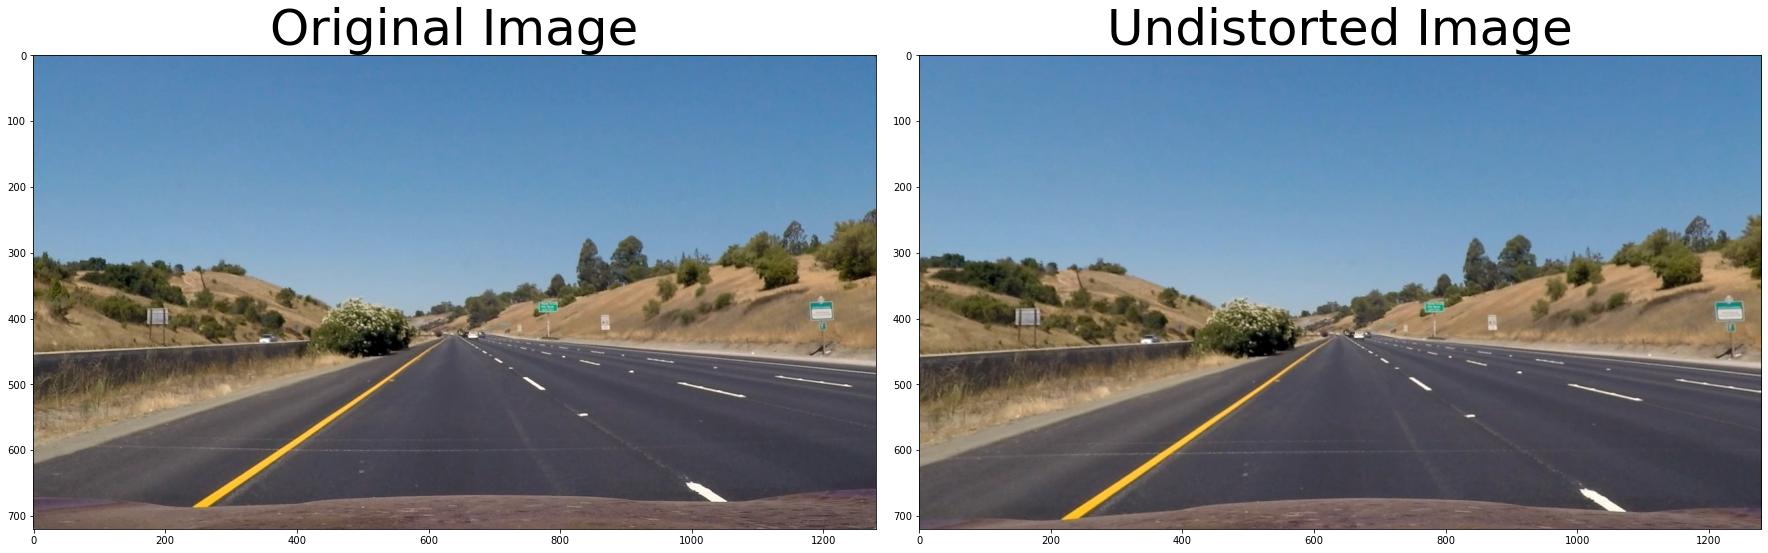

In [52]:
# img = cv2.imread('test_images/straight_lines1.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mpimg.imread('test_images/straight_lines1.jpg')

undistorted = cv2.undistort(img, cam_matrix, dist_coeff, None, cam_matrix)    
                   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)#,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

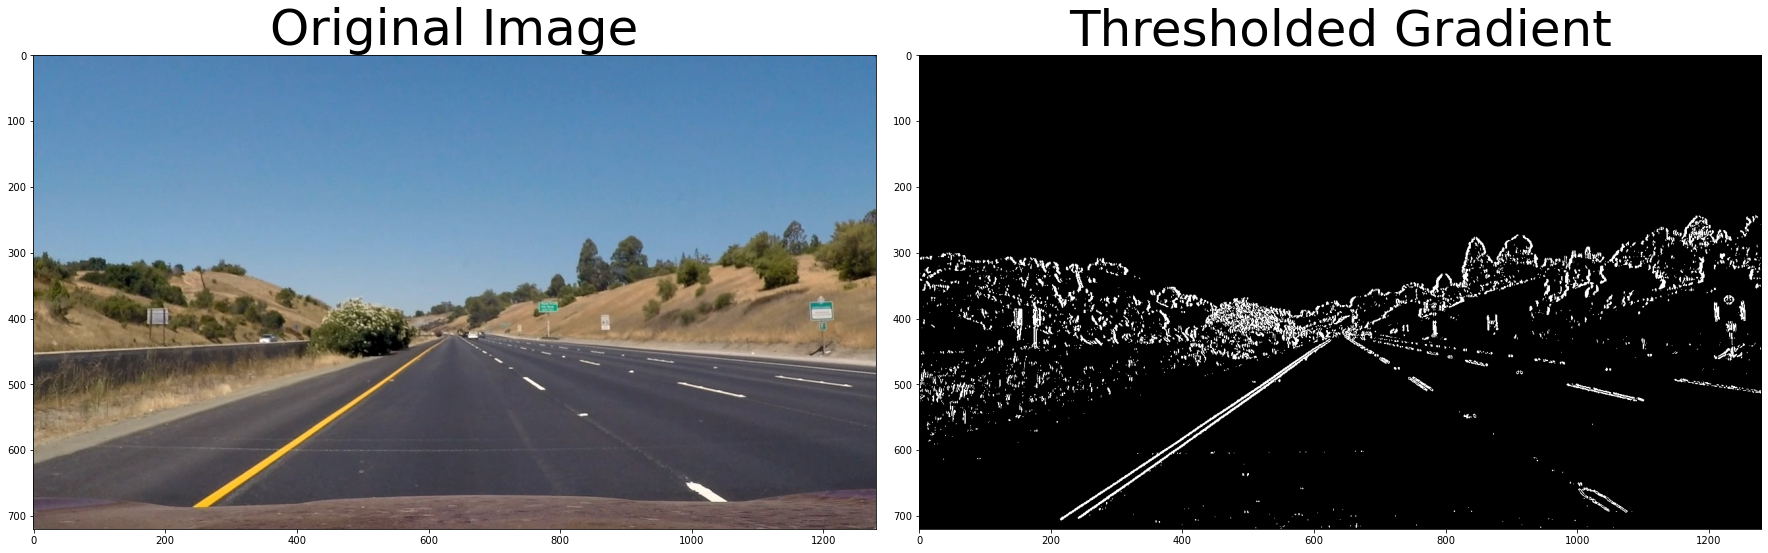

In [65]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

grad_binary = sobel.abs_thresh(undistorted, orient='x', thresh_min=20, thresh_max=120)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

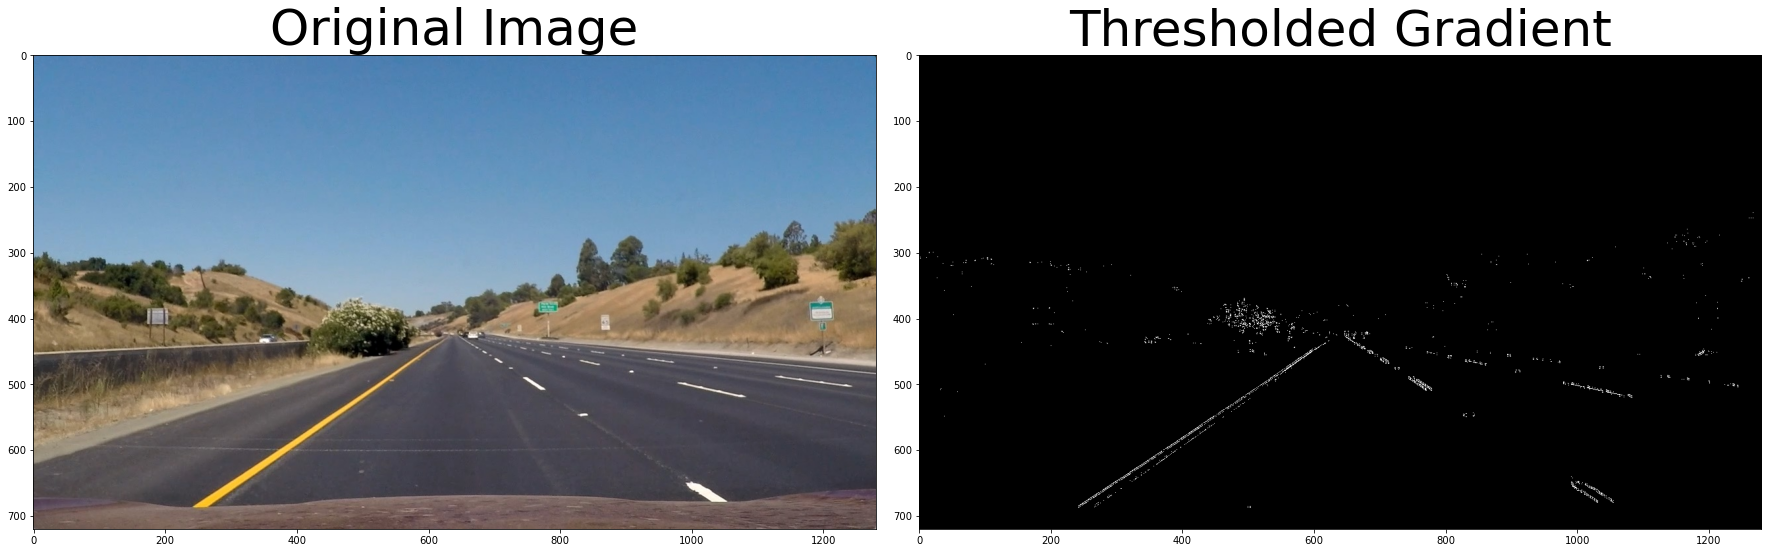

In [50]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

grad_binary = abs_sobel_thresh(img, orient='y', thresh_min=80, thresh_max=160)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)